In [1]:
import pandas as pd
import numpy as np

#we are using the SimpleImputer to fill missing values because using a more complex method 
#can be too computationally intensive since we are dealing with a large dataset.
from sklearn.impute import SimpleImputer

#we are using the Ordinal Encoder to encode categorical values since some features can take
#a variety of values which would not be suitable for applying One Hot Encoding
from sklearn.preprocessing import OrdinalEncoder

#we could go with Normalization or Standardization here but we decided with Standardization 
#because it would help us in the future when we come to Feature Selection
from sklearn.preprocessing import StandardScaler

#libraries given below are used in the process of Feature Selection. we are using RFE
#algorithm for feature selection. I used SelectKBest as well but RFE performed better 
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#we can use Principal Component Analysis on top of the selected feature set to further reduce the 
#number of features
from sklearn.decomposition import PCA

#here we are importing the packages for using the XGBoost Classifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#finally using Shapley to intepret the developed model
import shap

In [8]:
train_data = pd.read_csv("test.csv")
test_data = pd.read_csv("test.csv")

print('The shape of training dataset : ' + str(train_data.shape))
print('The shape of testing dataset : ' + str(test_data.shape))

The shape of training dataset : (7900, 14)
The shape of testing dataset : (7900, 14)


In [9]:
# Step 2: Identify good features and features with missing values
good_features = train_data.dropna(axis=1).columns.tolist()
missing_features = [col for col in train_data.columns if col not in good_features]

print(missing_features)
print(good_features)

['Number_of_Windows', 'Furnishing', 'Frequency_of_Powercuts', 'Crime_Rate', 'Dust_and_Noise']
['Id', 'Property_Type', 'Property_Area', 'Number_of_Doors', 'Power_Backup', 'Water_Supply', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review']


In [10]:
good_features.extend([missing_features[0]])

# Now good_features contains all good features and the first element of missing_features
print(good_features)

['Id', 'Property_Type', 'Property_Area', 'Number_of_Doors', 'Power_Backup', 'Water_Supply', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review', 'Number_of_Windows']


In [119]:
train1['Dust_and_Noise'] = train_data['Dust_and_Noise']
train1.head()

,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Number_of_Windows,Furnishing,Frequency_of_Powercuts,Crime_Rate,Dust_and_Noise
0,5.0,1521,1,1.0,0.0,7.61,156.0,4.71,5.0,2.0,0.0,3.0,Medium
1,5.0,2233,1,1.0,3.0,5.28,82.0,4.50,2.0,1.0,0.0,3.0,Medium
2,1.0,986,1,1.0,0.0,7.72,91.0,4.79,1.0,2.0,0.0,3.0,Medium
3,5.0,1625,1,1.0,2.0,6.19,159.0,4.09,2.0,1.0,0.0,3.0,Medium
4,5.0,1166,2,1.0,2.0,5.84,82.0,3.56,2.0,0.0,0.0,1.0,Medium


In [120]:
train1.shape

(7900, 13)

In [121]:
train1.head()

,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Number_of_Windows,Furnishing,Frequency_of_Powercuts,Crime_Rate,Dust_and_Noise
0,5.0,1521,1,1.0,0.0,7.61,156.0,4.71,5.0,2.0,0.0,3.0,Medium
1,5.0,2233,1,1.0,3.0,5.28,82.0,4.50,2.0,1.0,0.0,3.0,Medium
2,1.0,986,1,1.0,0.0,7.72,91.0,4.79,1.0,2.0,0.0,3.0,Medium
3,5.0,1625,1,1.0,2.0,6.19,159.0,4.09,2.0,1.0,0.0,3.0,Medium
4,5.0,1166,2,1.0,2.0,5.84,82.0,3.56,2.0,0.0,0.0,1.0,Medium


In [61]:
train1 = train1.drop(columns=['Id'])

In [122]:
categorical_features = ['Dust_and_Noise'] 

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform the categorical features
train1[categorical_features] = ordinal_encoder.fit_transform(train1[categorical_features])

In [123]:
train1.head()

,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Number_of_Windows,Furnishing,Frequency_of_Powercuts,Crime_Rate,Dust_and_Noise
0,5.0,1521,1,1.0,0.0,7.61,156.0,4.71,5.0,2.0,0.0,3.0,2.0
1,5.0,2233,1,1.0,3.0,5.28,82.0,4.50,2.0,1.0,0.0,3.0,2.0
2,1.0,986,1,1.0,0.0,7.72,91.0,4.79,1.0,2.0,0.0,3.0,2.0
3,5.0,1625,1,1.0,2.0,6.19,159.0,4.09,2.0,1.0,0.0,3.0,2.0
4,5.0,1166,2,1.0,2.0,5.84,82.0,3.56,2.0,0.0,0.0,1.0,2.0


In [124]:
test_set = train1[train1.isnull().any(axis=1)]
test_set.shape

(220, 13)

In [125]:
test_set.head()

,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Number_of_Windows,Furnishing,Frequency_of_Powercuts,Crime_Rate,Dust_and_Noise
46,4.0,913,2,1.0,0.0,6.04,90.0,4.17,4.000000,1.0,1.0,3.0,NaN
92,0.0,658,2,0.0,0.0,6.41,95.0,3.54,3.318533,0.0,1.0,1.0,NaN
111,4.0,1144,3,1.0,0.0,8.05,132.0,4.67,4.000000,1.0,0.0,3.0,NaN
129,5.0,1833,4,1.0,0.0,5.60,80.0,4.82,3.000000,1.0,0.0,3.0,NaN
155,1.0,302,1,1.0,0.0,6.64,89.0,2.92,1.000000,2.0,2.0,1.0,NaN


In [126]:
train1.dropna(axis=0, inplace=True)
train1.shape

(7680, 13)

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Separate features and target variable in train1
X_train = train1.drop(columns=['Dust_and_Noise'])
y_train = train1['Dust_and_Noise']

# Step 2: Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 3: Prepare features for prediction in test_set
X_test = test_set.drop(columns=['Dust_and_Noise'])

# Step 4: Predict values for 'Number_of_Windows' in X_test
predicted_values = model.predict(X_test)

# Print the predicted values
print(predicted_values)


[1.88845324 1.75776198 1.66373933 1.94227208 1.79161082 1.79673569
 1.88514261 1.70087785 1.76498646 1.85397124 1.89875921 1.71878773
 1.74674449 1.65575103 1.91812967 1.90311256 1.81251368 1.82831257
 1.65160138 1.51754859 1.7253876  1.99341087 1.78029589 1.77654434
 1.75451897 1.83025897 1.98974043 1.69305814 1.87428542 1.75851363
 1.76282709 1.78339422 1.59355481 1.57556047 1.75593104 1.69160343
 1.54584241 1.64648818 1.75862478 1.80075576 1.57590963 2.0187148
 1.87453618 1.94592307 1.77791606 1.80027815 1.78005303 1.66149872
 1.59735793 1.74252945 1.84802419 1.64187272 1.68519537 1.79494305
 1.83884099 1.81752453 1.70086011 1.96999704 1.7186328  1.7222166
 1.45672297 1.79038032 1.81551606 1.67729536 1.7865387  1.75569997
 1.75961748 1.92560638 1.88211142 1.59643049 1.62731467 1.94842638
 1.87168774 1.63284784 1.6974558  1.94057575 1.66738672 1.85839471
 1.80146531 1.44216444 1.62556998 1.68170405 1.68428352 1.8140142
 1.73453442 1.53295071 1.47712218 1.83516556 1.6069589  1.8149302

In [128]:
# Step 1: Add predicted values as a new column to test_set
test_set['Dust_and_Noise'] = predicted_values

# Concatenate the two parts back together
combined_test = pd.concat([train1, test_set])

# Ensure the original order is preserved
combined_test.sort_index(inplace=True)

# Print the combined data
print(combined_test)

      Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0               5.0           1521                1           1.0   
1               5.0           2233                1           1.0   
2               1.0            986                1           1.0   
3               5.0           1625                1           1.0   
4               5.0           1166                2           1.0   
...             ...            ...              ...           ...   
7895            5.0           1120                2           1.0   
7896            1.0            445                3           1.0   
7897            2.0           3780                6           2.0   
7898            5.0           1266                1           1.0   
7899            5.0           1229                4           1.0   

      Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0              0.0                   7.61              156.0   
1              3.0                   5.28  


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [129]:
combined_test.head(20)

,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Number_of_Windows,Furnishing,Frequency_of_Powercuts,Crime_Rate,Dust_and_Noise
0,5.0,1521,1,1.0,0.0,7.61,156.0,4.71,5.000000,2.0,0.000000,3.000000,2.0
1,5.0,2233,1,1.0,3.0,5.28,82.0,4.50,2.000000,1.0,0.000000,3.000000,2.0
2,1.0,986,1,1.0,0.0,7.72,91.0,4.79,1.000000,2.0,0.000000,3.000000,2.0
3,5.0,1625,1,1.0,2.0,6.19,159.0,4.09,2.000000,1.0,0.000000,3.000000,2.0
4,5.0,1166,2,1.0,2.0,5.84,82.0,3.56,2.000000,0.0,0.000000,1.000000,2.0
5,2.0,1883,5,1.0,0.0,6.90,151.0,4.72,5.000000,0.0,0.000000,2.707255,2.0
6,1.0,880,2,2.0,0.0,5.59,97.0,3.54,2.000000,1.0,0.751265,1.000000,2.0
7,1.0,350,2,1.0,0.0,7.34,102.0,4.78,3.000000,2.0,0.000000,3.000000,2.0
8,1.0,661,3,1.0,3.0,7.36,90.0,3.85,1.000000,2.0,1.000000,3.000000,2.0
9,2.0,2147,4,1.0,0.0,6.96,123.0,4.76,5.000000,1.0,0.000000,3.000000,2.0


In [130]:
combined_test.shape

(7900, 13)

In [131]:
print(combined_test.isnull().sum())

Property_Type             0
Property_Area             0
Number_of_Doors           0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Air_Quality_Index         0
Neighborhood_Review       0
Number_of_Windows         0
Furnishing                0
Frequency_of_Powercuts    0
Crime_Rate                0
Dust_and_Noise            0
dtype: int64


In [25]:
# combined_test['Number_of_Windows'] = train_data['Number_of_Windows']

# # Print the head of the combined dataset to verify
# print(combined_test.head())

   Property_Type  Property_Area  Number_of_Doors  Power_Backup  Water_Supply  \
0            5.0           1521                1           1.0           0.0   
1            5.0           2233                1           1.0           3.0   
2            1.0            986                1           1.0           0.0   
3            5.0           1625                1           1.0           2.0   
4            5.0           1166                2           1.0           2.0   

   Traffic_Density_Score  Air_Quality_Index  Neighborhood_Review  \
0                   7.61              156.0                 4.71   
1                   5.28               82.0                 4.50   
2                   7.72               91.0                 4.79   
3                   6.19              159.0                 4.09   
4                   5.84               82.0                 3.56   

   Number_of_Windows  
0                5.0  
1                2.0  
2                1.0  
3                2

In [132]:
combined_test.shape

(7900, 13)

In [118]:
train1 = combined_test

In [135]:
combined_test.to_csv('combined_test.csv', index=False) 

## after handling missing values start from here

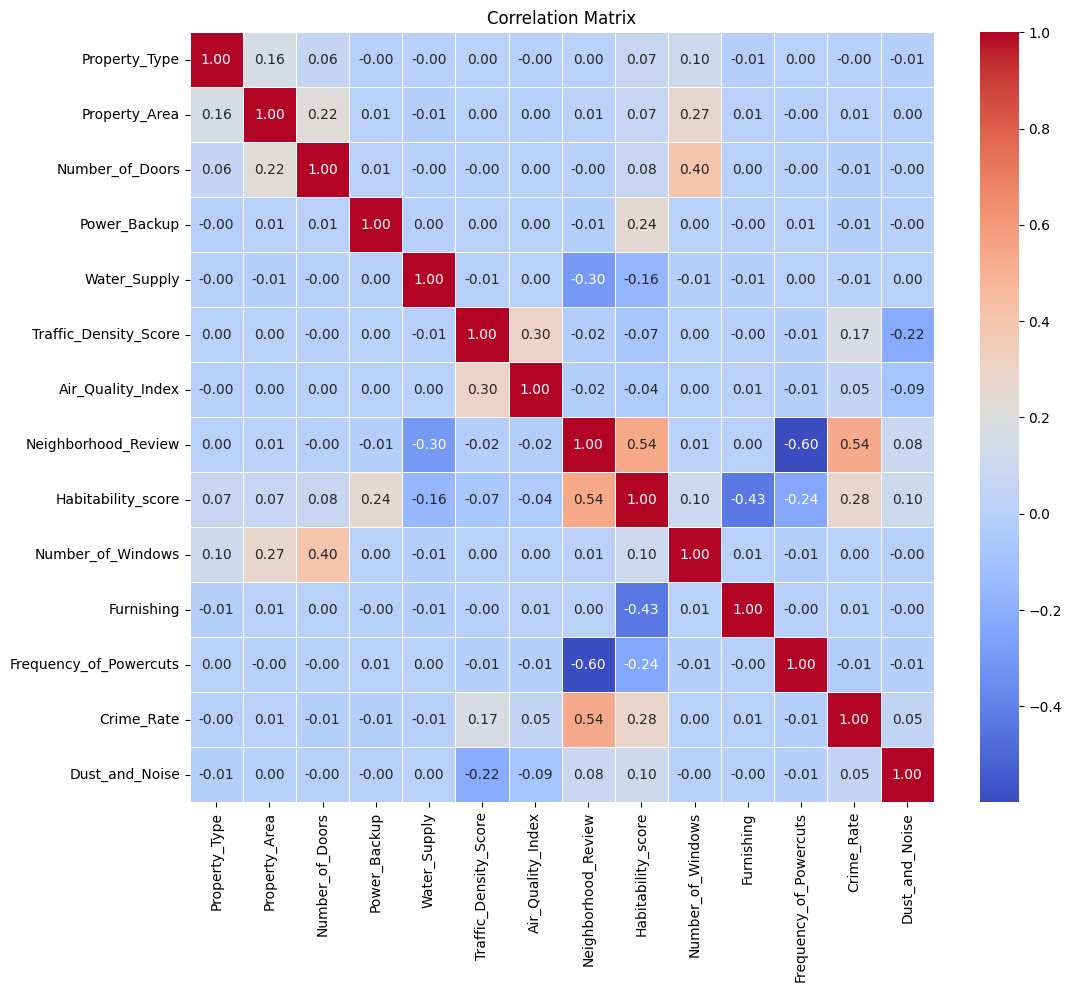

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

# Compute the correlation matrix
corr_matrix = combined_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assuming train_data contains your preprocessed dataset with features and target variable
# Splitting the data into features (X) and target variable (y)
X = combined_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = combined_data['Habitability_score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the XGBRegressor model
xgb_regressor = XGBRegressor()

# Fitting the model to the training data
xgb_regressor.fit(X_train, y_train)

# Making predictions on the test data
y_pred = xgb_regressor.predict(X_test)

# Evaluating the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 35.39857599666684


In [97]:
from sklearn.ensemble import RandomForestRegressor

# Assuming train_data contains your preprocessed dataset with features and target variable
# Splitting the data into features (X) and target variable (y)
X = combined_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = combined_data['Habitability_score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the RandomForestRegressor model
rf_regressor = RandomForestRegressor()

# Fitting the model to the training data
rf_regressor.fit(X_train, y_train)

# Making predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluating the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Random Forest):", mse)


Mean Squared Error (Random Forest): 31.1414389723212


In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

# Assuming train_data contains your preprocessed dataset with features and target variable
# Splitting the data into features (X) and target variable (y)
X = combined_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = combined_data['Habitability_score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the ExtraTreesRegressor model
extra_trees_regressor = ExtraTreesRegressor()

# Fitting the model to the training data
extra_trees_regressor.fit(X_train, y_train)

# Making predictions on the test data
y_pred = extra_trees_regressor.predict(X_test)

# Evaluating the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Extra Trees):", mse)


Mean Squared Error (Extra Trees): 32.82397705045095


In [139]:
combined_data = pd.read_csv("combined_data.csv")

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split

# Assuming train_data contains your preprocessed dataset with features and target variable
# Splitting the data into features (X) and target variable (y)
X = combined_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = combined_data['Habitability_score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the GaussianProcessRegressor model
kernel = DotProduct() + WhiteKernel()
gp_regressor = GaussianProcessRegressor(kernel=kernel)

# Fitting the model to the training data
gp_regressor.fit(X_train, y_train)

# Making predictions on the test data
y_pred = gp_regressor.predict(X_test)

# Evaluating the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Gaussian Process):", mse)


In [142]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

X = cleaned_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = cleaned_data['Habitability_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train base models
rf_model = RandomForestRegressor()
xgb_model = XGBRegressor()
et_model = ExtraTreesRegressor()

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
et_model.fit(X_train, y_train)

# Make predictions on the test data using base models
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
et_preds = et_model.predict(X_test)

# Create stacked dataset
stacked_X_train = np.column_stack((rf_preds, xgb_preds, et_preds))

# Train meta-learner (e.g., Linear Regression) on stacked dataset
meta_learner = LinearRegression()
meta_learner.fit(stacked_X_train, y_test)

# Make predictions on the test data using meta-learner
stacked_preds = meta_learner.predict(stacked_X_train)

# Evaluate performance
mse_stacked = mean_squared_error(y_test, stacked_preds)
print("Mean Squared Error (Stacked Model):", mse_stacked)


Mean Squared Error (Stacked Model): 29.247212585769148


In [138]:
import pandas as pd

# Assuming test_data contains the test dataset without the 'Id' column
test_data = pd.read_csv("combined_test.csv")
test1 = pd.read_csv("test.csv")

# Make predictions on the test data using base models
rf_preds = rf_model.predict(test_data)
xgb_preds = xgb_model.predict(test_data)
et_preds = et_model.predict(test_data)

# Create stacked dataset
stacked_test_data = np.column_stack((rf_preds, xgb_preds, et_preds))

# Make predictions on the stacked test data using meta-learner
stacked_preds = meta_learner.predict(stacked_test_data)

# Add the predictions to the test_data DataFrame
test_data['Habitability_score'] = stacked_preds

test_data.head()

# Create a new DataFrame with 'Id' and 'Habitability_score' columns
predictions_df = pd.DataFrame({'Id': test1['Id'], 'Habitability_score': test_data['Habitability_score']})

# Write the predictions to a new CSV file
predictions_df.to_csv("predicted_test1.csv", index=False)

In [120]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for each model
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

et_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV for each model
rf_grid = GridSearchCV(RandomForestRegressor(), rf_param_grid, scoring='neg_mean_squared_error', cv=5)
xgb_grid = GridSearchCV(XGBRegressor(), xgb_param_grid, scoring='neg_mean_squared_error', cv=5)
et_grid = GridSearchCV(ExtraTreesRegressor(), et_param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the models with hyperparameter tuning
rf_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)
et_grid.fit(X_train, y_train)

# Get the best models
best_rf_model = rf_grid.best_estimator_
best_xgb_model = xgb_grid.best_estimator_
best_et_model = et_grid.best_estimator_

# Make predictions on the test data using the best models
best_rf_preds = best_rf_model.predict(X_test)
best_xgb_preds = best_xgb_model.predict(X_test)
best_et_preds = best_et_model.predict(X_test)

# Create stacked dataset with best models
best_stacked_X_train = np.column_stack((best_rf_preds, best_xgb_preds, best_et_preds))

# Train meta-learner (e.g., Linear Regression) on stacked dataset
best_meta_learner = LinearRegression()
best_meta_learner.fit(best_stacked_X_train, y_test)

# Make predictions on the test data using the meta-learner with best models
best_stacked_preds = best_meta_learner.predict(best_stacked_X_train)

# Evaluate performance
mse_best_stacked = mean_squared_error(y_test, best_stacked_preds)
print("Mean Squared Error (Stacked Model with Hyperparameter Tuning):", mse_best_stacked)


Mean Squared Error (Stacked Model with Hyperparameter Tuning): 29.601231819541614


In [123]:
# Get the best hyperparameters for RandomForestRegressor
best_rf_params = best_rf_model.get_params

# Get the best hyperparameters for XGBRegressor
best_xgb_params = best_xgb_model.get_params

# Get the best hyperparameters for ExtraTreesRegressor
best_et_params = best_et_model.get_params

print("Best Hyperparameters for RandomForestRegressor:", best_rf_params)
print("Best Hyperparameters for XGBRegressor:", best_xgb_params)
print("Best Hyperparameters for ExtraTreesRegressor:", best_et_params)

Best Hyperparameters for RandomForestRegressor: <bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=200)>
Best Hyperparameters for XGBRegressor: <bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)>
Best Hyperparame

In [140]:
import numpy as np

# Calculate Z-score for each feature
z_scores = (combined_data - combined_data.mean()) / combined_data.std()

# Set the threshold for Z-score
z_threshold = 3  # Adjust this threshold as needed

# Find outliers based on Z-score
outliers_z_score = (z_scores > z_threshold) | (z_scores < -z_threshold)

# Calculate IQR for each feature
Q1 = combined_data.quantile(0.25)
Q3 = combined_data.quantile(0.75)
IQR = Q3 - Q1

# Set the threshold for IQR
iqr_threshold = 1.5  # Adjust this threshold as needed

# Find outliers based on IQR
outliers_iqr = (combined_data < (Q1 - iqr_threshold * IQR)) | (combined_data > (Q3 + iqr_threshold * IQR))

# Combine outliers detected by both methods
outliers_combined = outliers_z_score | outliers_iqr

# Count the number of outliers for each feature
outliers_count = outliers_combined.sum()

# Print the number of outliers for each feature
print("Number of outliers for each feature:")
print(outliers_count)


Number of outliers for each feature:
Property_Type                0
Property_Area             1372
Number_of_Doors            724
Power_Backup              7803
Water_Supply                 0
Traffic_Density_Score      447
Air_Quality_Index          628
Neighborhood_Review        554
Habitability_score        2672
Number_of_Windows         1604
Furnishing                   0
Frequency_of_Powercuts     977
Crime_Rate                   0
Dust_and_Noise            5223
dtype: int64


In [141]:
# Filter out rows containing outliers
cleaned_data = combined_data[
    (combined_data['Property_Area'].between(combined_data['Property_Area'].quantile(0.05), combined_data['Property_Area'].quantile(0.95))) &
    (combined_data['Number_of_Doors'].between(combined_data['Number_of_Doors'].quantile(0.05), combined_data['Number_of_Doors'].quantile(0.95))) &
    (combined_data['Power_Backup'].between(combined_data['Power_Backup'].quantile(0.05), combined_data['Power_Backup'].quantile(0.95))) &
    (combined_data['Traffic_Density_Score'].between(combined_data['Traffic_Density_Score'].quantile(0.05), combined_data['Traffic_Density_Score'].quantile(0.95))) &
    (combined_data['Air_Quality_Index'].between(combined_data['Air_Quality_Index'].quantile(0.05), combined_data['Air_Quality_Index'].quantile(0.95))) &
    (combined_data['Neighborhood_Review'].between(combined_data['Neighborhood_Review'].quantile(0.05), combined_data['Neighborhood_Review'].quantile(0.95))) &
    (combined_data['Number_of_Windows'].between(combined_data['Number_of_Windows'].quantile(0.05), combined_data['Number_of_Windows'].quantile(0.95))) &
    (combined_data['Frequency_of_Powercuts'].between(combined_data['Frequency_of_Powercuts'].quantile(0.05), combined_data['Frequency_of_Powercuts'].quantile(0.95))) &
    (combined_data['Dust_and_Noise'].between(combined_data['Dust_and_Noise'].quantile(0.05), combined_data['Dust_and_Noise'].quantile(0.95)))
]

# Display the shape of the cleaned dataset
print("Shape of cleaned dataset:", cleaned_data.shape)


Shape of cleaned dataset: (19913, 14)


In [119]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

X = combined_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = combined_data['Habitability_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train base models
rf_model = RandomForestRegressor()
xgb_model = XGBRegressor()
et_model = ExtraTreesRegressor()
ridge_model = Ridge()
lasso_model = Lasso()

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
et_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

# Make predictions on the test data using base models
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
et_preds = et_model.predict(X_test)
ridge_preds = ridge_model.predict(X_test)
lasso_preds = lasso_model.predict(X_test)

# Create stacked dataset
stacked_X_train = np.column_stack((rf_preds, xgb_preds, et_preds, ridge_preds, lasso_preds))

# Train meta-learner (e.g., Linear Regression) on stacked dataset
meta_learner = LinearRegression()
meta_learner.fit(stacked_X_train, y_test)

# Make predictions on the test data using meta-learner
stacked_preds = meta_learner.predict(stacked_X_train)

# Evaluate performance
mse_stacked = mean_squared_error(y_test, stacked_preds)
print("Mean Squared Error (Stacked Model):", mse_stacked)


Mean Squared Error (Stacked Model): 30.285102957838415


In [115]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train base models
ada_model = AdaBoostRegressor()
gb_model = GradientBoostingRegressor()
ridge_model = Ridge()
lasso_model = Lasso()
svr_model = SVR()
knn_model = KNeighborsRegressor()
dt_model = DecisionTreeRegressor()

ada_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Make predictions on the test data using base models
ada_preds = ada_model.predict(X_test)
gb_preds = gb_model.predict(X_test)
ridge_preds = ridge_model.predict(X_test)
lasso_preds = lasso_model.predict(X_test)
svr_preds = svr_model.predict(X_test)
knn_preds = knn_model.predict(X_test)
dt_preds = dt_model.predict(X_test)

# Create stacked dataset
stacked_X_train = np.column_stack((ada_preds, gb_preds, ridge_preds, lasso_preds,
                                   svr_preds, knn_preds, dt_preds))

# Train meta-learner (e.g., Linear Regression) on stacked dataset
meta_learner = LinearRegression()
meta_learner.fit(stacked_X_train, y_test)

# Make predictions on the test data using meta-learner
stacked_preds = meta_learner.predict(stacked_X_train)

# Evaluate performance
mse_stacked = mean_squared_error(y_test, stacked_preds)
print("Mean Squared Error (Stacked Model):", mse_stacked)


Mean Squared Error (Stacked Model): 35.78323693071617
